In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))

In [2]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Cardiomyocyte/code"

In [3]:
coembed <- readRDS("../data/coembed/coembed.Rds")
coembed

An object of class Seurat 
230075 features across 83020 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

Length of unique values greater than palette, interpolating..



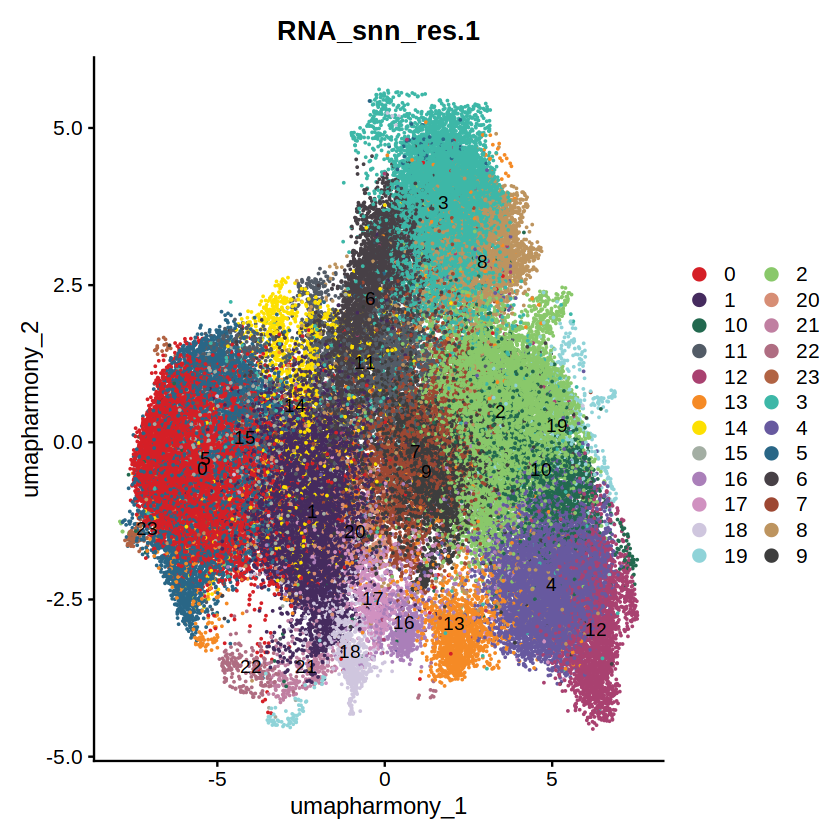

In [4]:
cols <- ArchR::paletteDiscrete(coembed@meta.data[, glue::glue("RNA_snn_res.1")])
DimPlot(coembed, reduction = "umap_harmony", group.by = "RNA_snn_res.1", cols = cols, label = TRUE)

In [5]:
## get number of cells per cluster and sample
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., tech == "RNA") %>%
    group_by(orig.ident, RNA_snn_res.1) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(names_from = RNA_snn_res.1, values_from = count, values_fill = 0)

write.csv(df_count, "../data/coembed/stat_cell_counts_per_sample_rna.csv", row.names = FALSE)

`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.



`summarise()` has grouped output by 'RNA_snn_res.1'. You can override using the `.groups` argument.



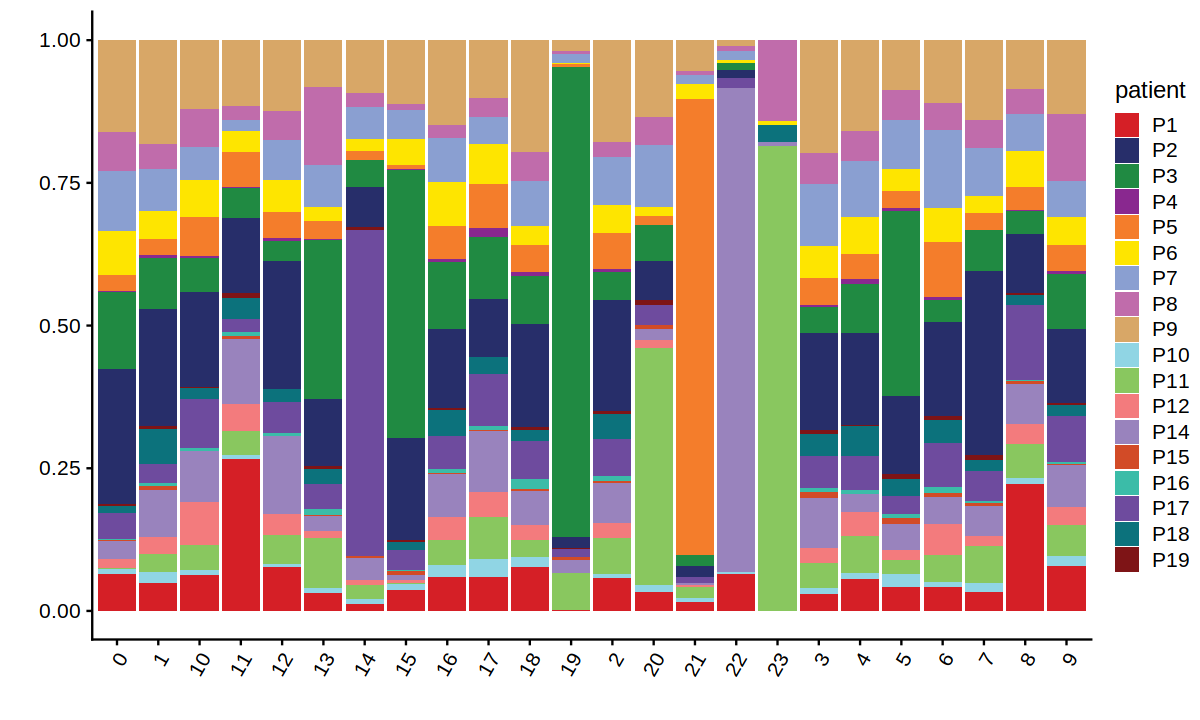

In [6]:
## check cell proportion across patients and modalities
meta.data <- as.data.frame(coembed@meta.data)

cols.patient <- ArchR::paletteDiscrete(meta.data$patient)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.1, patient) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.1, cell_proportion, fill=patient)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.patient) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'RNA_snn_res.1'. You can override using the `.groups` argument.



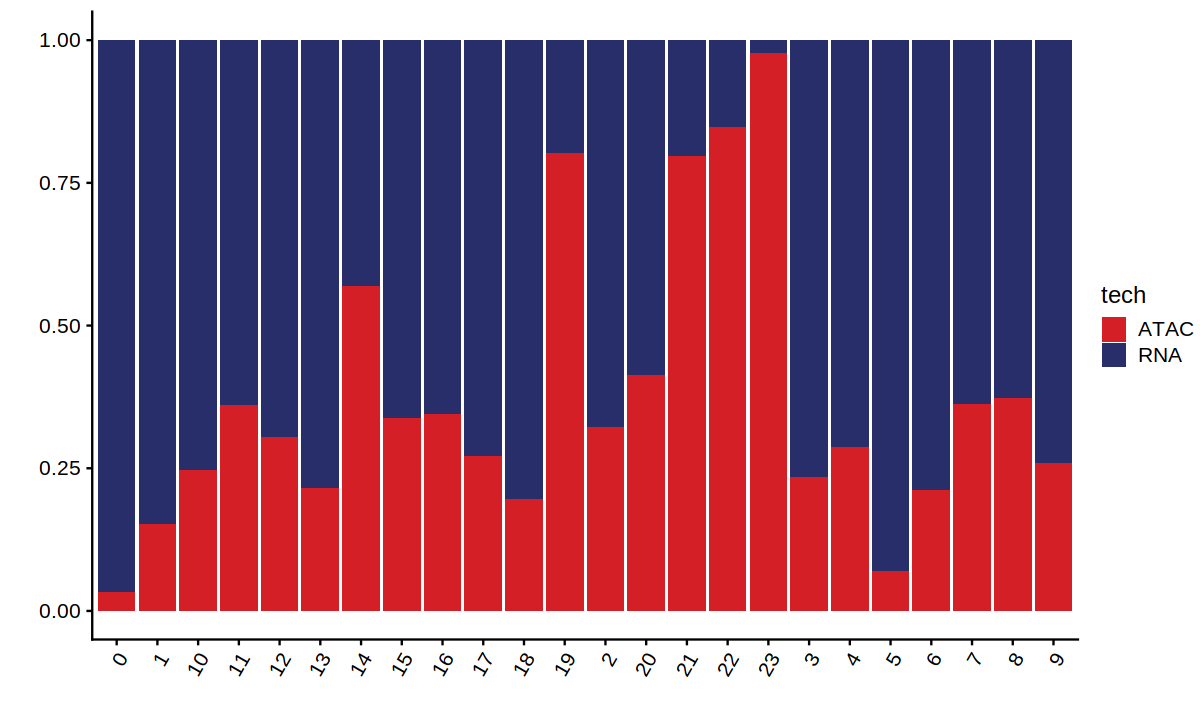

In [7]:
cols.tech <- ArchR::paletteDiscrete(meta.data$tech)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.1, tech) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.1, cell_proportion, fill=tech)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.tech) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

An object of class Seurat 
230075 features across 59045 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

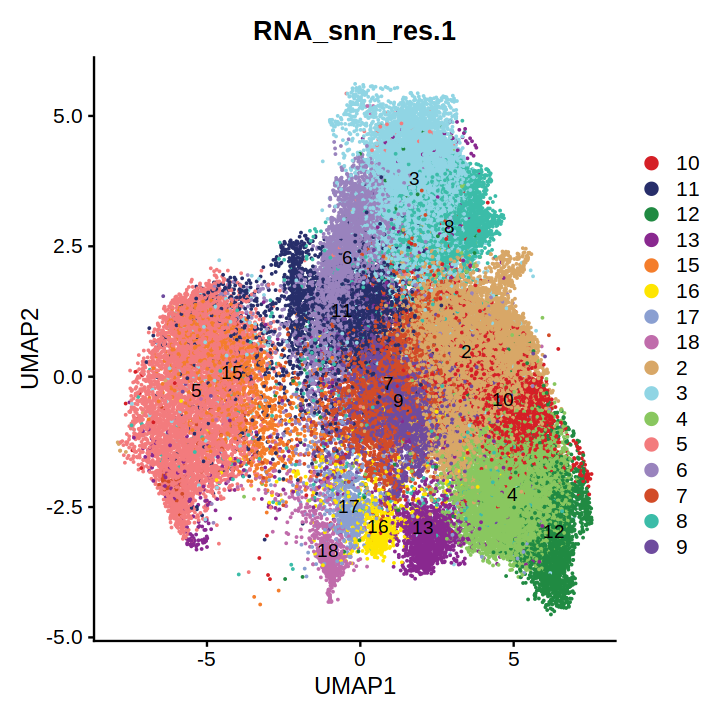

In [8]:
Idents(coembed) <- "RNA_snn_res.1"
coembed.sub <- subset(coembed, idents = c(0, 1, 14, 19, 20, 21, 22, 23), invert = TRUE)
coembed.sub

cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, "RNA_snn_res.1"])

options(repr.plot.height = 6, repr.plot.width = 6)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.1", label = TRUE,
             reduction = "umap_harmony", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [9]:
coembed.sub <- RunUMAP(coembed.sub, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony_v2",
               reduction.ke = 'umap_harmony_v2_',
              verbose = FALSE,
                   min.dist = 0.4)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_harmony_v2_ to umapharmonyv2_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umapharmonyv2_”


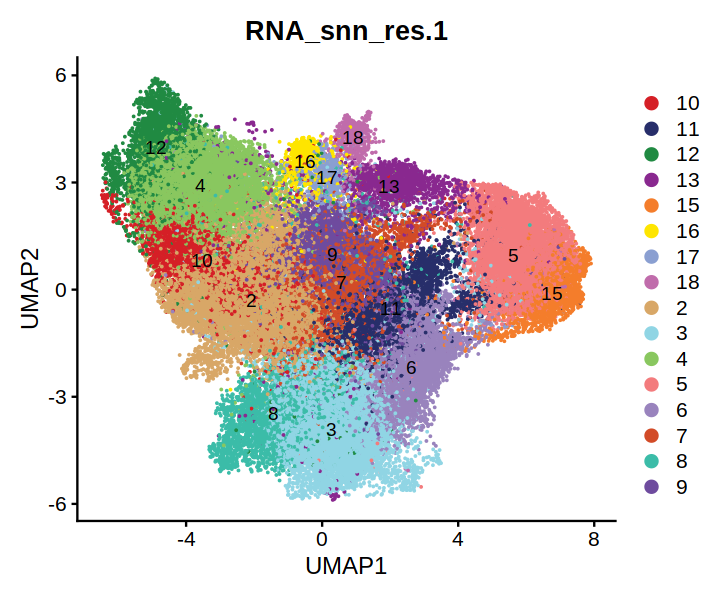

In [10]:
options(repr.plot.height = 5, repr.plot.width = 6)

DimPlot(coembed.sub, group.by = "RNA_snn_res.1", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

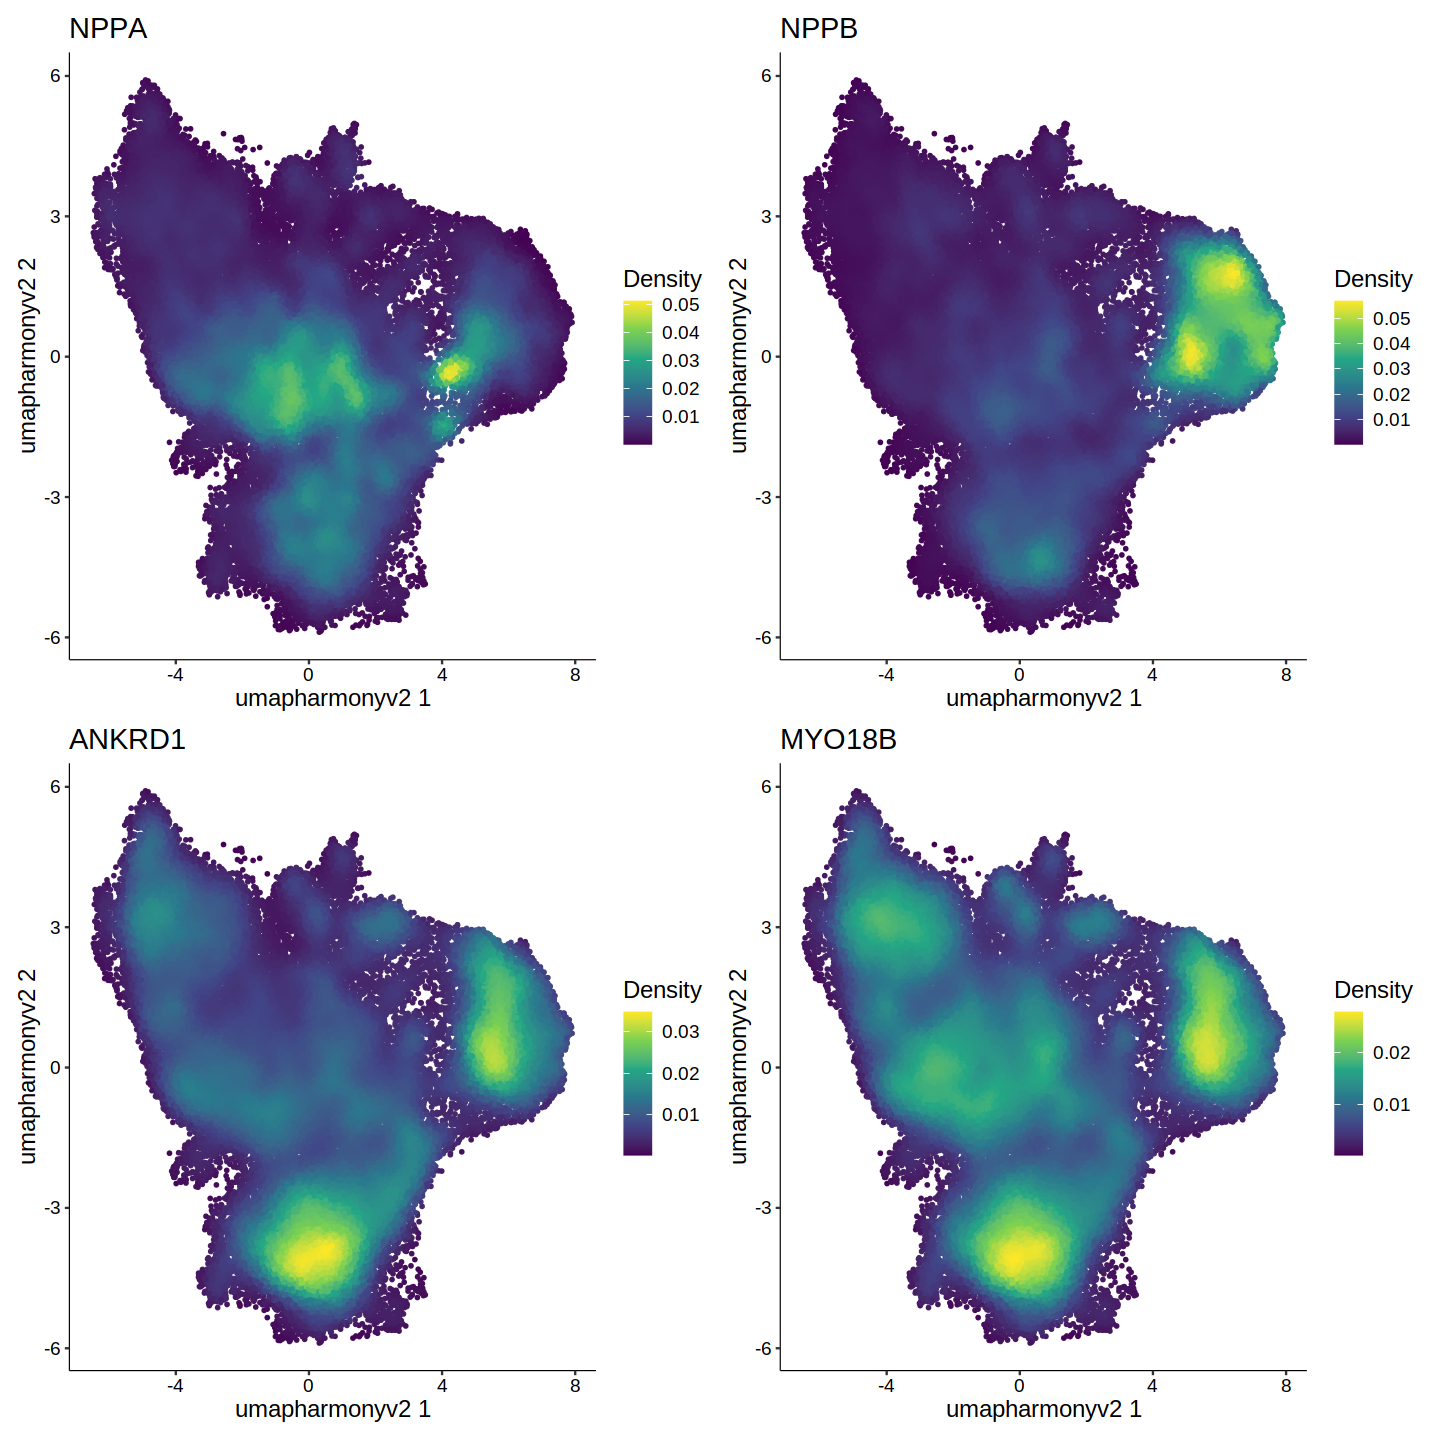

In [11]:
options(repr.plot.height = 12, repr.plot.width = 12)

p1 <- plot_density(coembed.sub, features="NPPA", reduction="umap_harmony_v2")
p2 <- plot_density(coembed.sub, features="NPPB", reduction="umap_harmony_v2")
p3 <- plot_density(coembed.sub, features="ANKRD1", reduction="umap_harmony_v2")
p4 <- plot_density(coembed.sub, features="MYO18B", reduction="umap_harmony_v2")

patchwork::wrap_plots(list(p1, p2, p3, p4), nrow = 2)

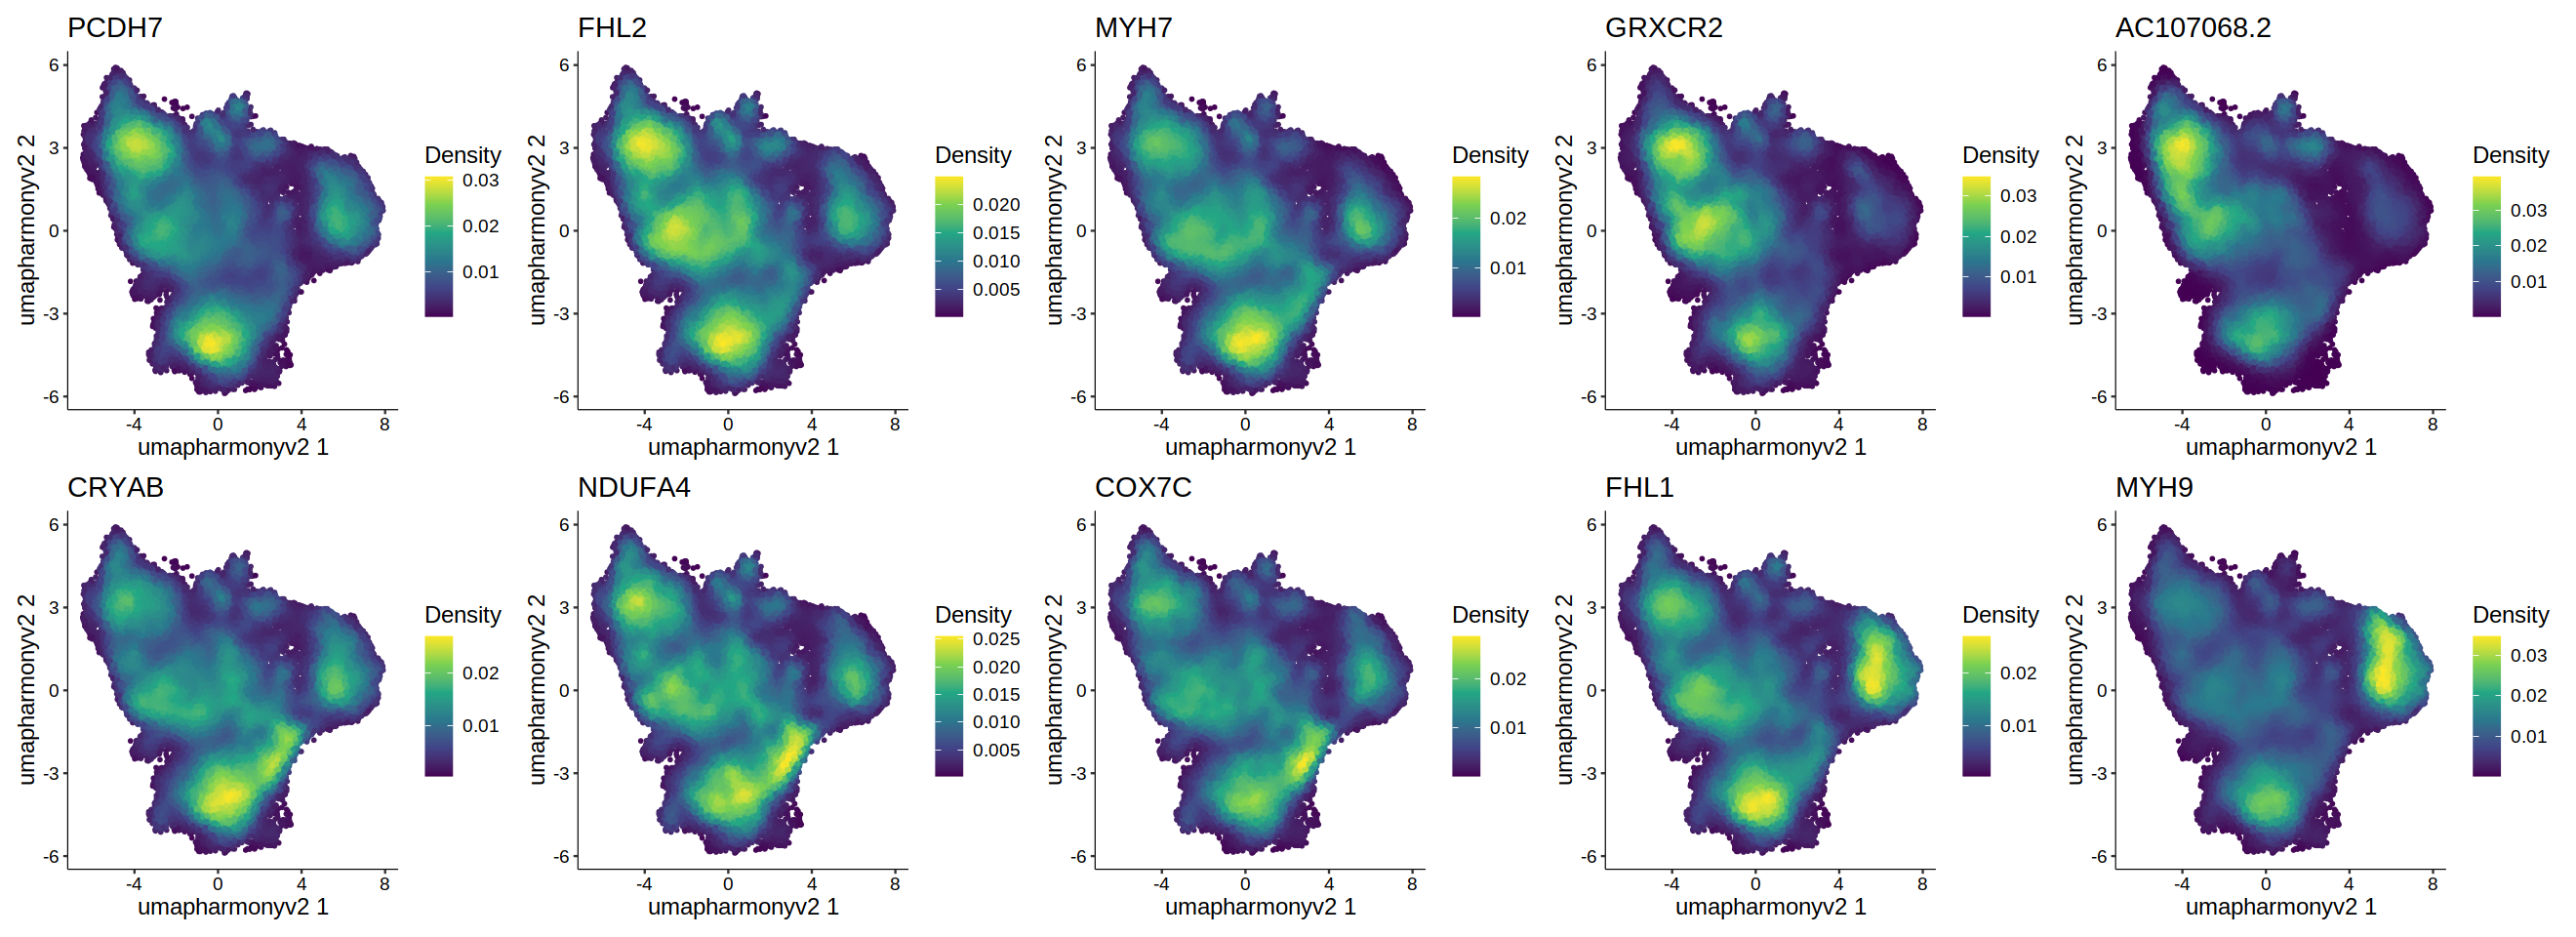

In [12]:
options(repr.plot.height = 8, repr.plot.width = 22)

p1 <- plot_density(coembed.sub, features="PCDH7", reduction="umap_harmony_v2")
p2 <- plot_density(coembed.sub, features="FHL2", reduction="umap_harmony_v2")
p3 <- plot_density(coembed.sub, features="MYH7", reduction="umap_harmony_v2")
p4 <- plot_density(coembed.sub, features="GRXCR2", reduction="umap_harmony_v2")
p5 <- plot_density(coembed.sub, features="AC107068.2", reduction="umap_harmony_v2")
p6 <- plot_density(coembed.sub, features="CRYAB", reduction="umap_harmony_v2")
p7 <- plot_density(coembed.sub, features="NDUFA4", reduction="umap_harmony_v2")
p8 <- plot_density(coembed.sub, features="COX7C", reduction="umap_harmony_v2")
p9 <- plot_density(coembed.sub, features="FHL1", reduction="umap_harmony_v2")
p10 <- plot_density(coembed.sub, features="MYH9", reduction="umap_harmony_v2")

patchwork::wrap_plots(list(p1, p2, p3, p4, p5, 
                           p6, p7, p8, p9, p10), nrow = 2)

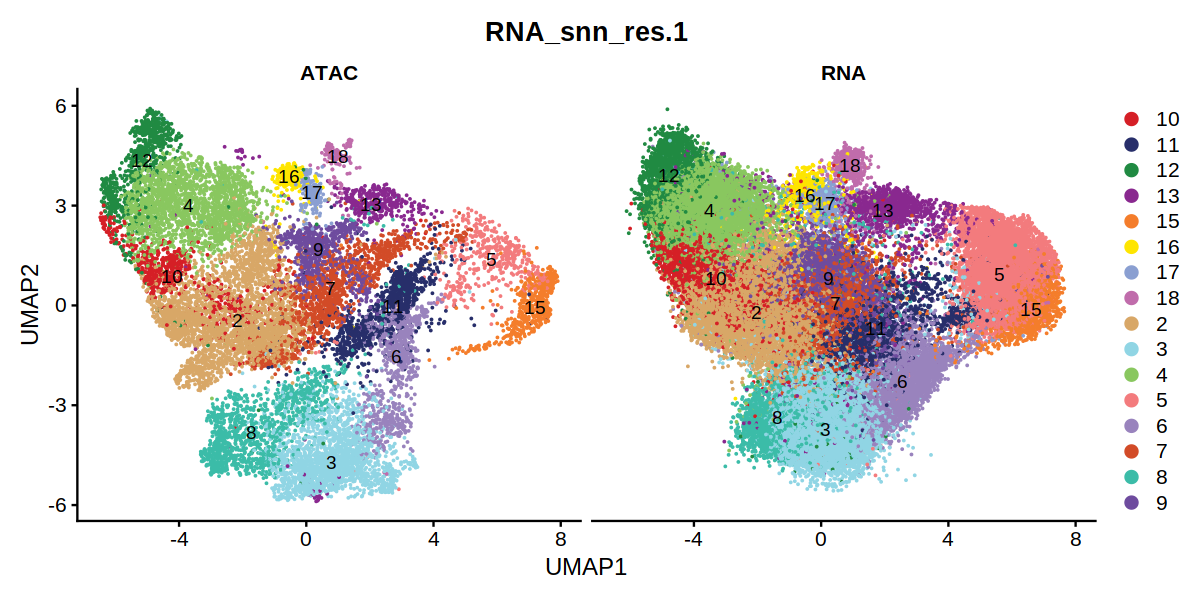

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.1", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, split.by = "tech", cols=cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [14]:
## re-clustering
resolutions <- seq(0.1, 1, 0.1)

coembed.sub <- FindNeighbors(coembed.sub, reduction = "harmony", dims = 1:30)
coembed.sub <- FindClusters(coembed.sub, resolution = resolutions, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



ERROR: Error in RunModularityClusteringCpp(SNN, modularity, resolution, algorithm, : c++ exception (unknown reason)


In [ ]:
library(clustree)

options(repr.plot.height = 8, repr.plot.width = 12)

clustree(coembed.sub, prefix = "RNA_snn_res.")

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 22)

plotlist <- lapply(resolutions, function(x){
    cols <- ArchR::paletteDiscrete(coembed.sub@meta.data[, glue::glue("RNA_snn_res.{x}")])
    
    p <- DimPlot(coembed.sub, group.by = glue::glue("RNA_snn_res.{x}"), label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE) +
    scale_color_manual(values = cols) +
    xlab("UMAP1") + ylab("UMAP2")
    
    p
})

p <- patchwork::wrap_plots(plotlist, nrow = 2)

p

In [ ]:
meta.data <- as.data.frame(coembed.sub@meta.data)

cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, glue::glue("RNA_snn_res.0.1")])

In [ ]:
df_plot <-  meta.data %>%
    group_by(patient, RNA_snn_res.0.1) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient, cell_proportion, fill=RNA_snn_res.0.1)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

In [ ]:
df_plot <- meta.data %>%
    group_by(region, RNA_snn_res.0.1) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(region, cell_proportion, fill=RNA_snn_res.0.1)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

In [ ]:
df_plot <- meta.data %>%
    group_by(patient_group, RNA_snn_res.0.1) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient_group, cell_proportion, fill=RNA_snn_res.0.1)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 6, repr.plot.height = 6)

p1

In [ ]:
df_plot <- meta.data %>% 
            group_by(patient_region_id, RNA_snn_res.0.1) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts))

df_anno <- coembed.sub@meta.data %>%
    as.data.frame() %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)
    
p <- ggplot(data = df_plot, aes(x = patient_group, y = proportion)) +
    geom_boxplot2(aes(color = patient_group)) +
    facet_wrap(~RNA_snn_res.0.1, nrow = 1) +
    stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                         c("group_2", "group_3"),
                                         c("group_1", "group_3")),
                   method = "wilcox.test") +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_blank(),
         legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5)

print(p)

In [ ]:
Idents(coembed.sub) <- "RNA_snn_res.0.1"

In [ ]:
all.markers <- FindAllMarkers(coembed.sub, only.pos = TRUE, min.pct = 0.25)
    
df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

p <- DotPlot(coembed.sub, features = unique(df$gene)) + RotatedAxis()
    
options(repr.plot.height = 5, repr.plot.width = 15)

print(p)

In [ ]:
if(!dir.exists("../data/coembed/MarkerGenesAfterCleaning")){
    dir.create("../data/coembed/MarkerGenesAfterCleaning")
}

markerList <- split(all.markers, all.markers$cluster)
    
for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
}
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.0.1.xlsx"),
                   SheetNames = names(markerList))

saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.0.1.rds"))

In [ ]:
saveRDS(coembed.sub, file = "../data/coembed/coembed.cleaning.Rds")

In [ ]:
sessionInfo()